C= 0.10, B=10,  E=1
Dataset MNIST Loaded!
Round 1 | ids: [7, 20, 24, 34, 40, 51, 59, 73, 80, 99] | average accuracy: 0.8590 | train loss: 0.4697 | test loss: 0.5612
Round 2 | ids: [5, 21, 38, 43, 49, 51, 63, 75, 79, 99] | average accuracy: 0.9044 | train loss: 0.3794 | test loss: 0.3489
Round 3 | ids: [16, 26, 35, 45, 51, 57, 67, 68, 70, 78] | average accuracy: 0.9101 | train loss: 0.3885 | test loss: 0.3001
Round 4 | ids: [1, 11, 14, 16, 20, 28, 51, 71, 74, 88] | average accuracy: 0.9129 | train loss: 0.4157 | test loss: 0.2831
Round 5 | ids: [0, 1, 2, 22, 24, 27, 48, 58, 74, 83] | average accuracy: 0.9304 | train loss: 0.2616 | test loss: 0.2314
Round 6 | ids: [1, 6, 17, 25, 46, 50, 59, 62, 85, 98] | average accuracy: 0.9283 | train loss: 0.4251 | test loss: 0.2229
Round 7 | ids: [10, 14, 16, 21, 22, 53, 60, 68, 83, 92] | average accuracy: 0.9390 | train loss: 0.1371 | test loss: 0.1964
Round 8 | ids: [0, 15, 27, 52, 56, 70, 84, 87, 92, 94] | average accuracy: 0.9425 | train loss: 0.

Round 50 | ids: [1, 17, 19, 27, 35, 55, 62, 85, 95, 99] | average accuracy: 0.9755 | train loss: 0.0019 | test loss: 0.0800
C= 0.10, B=10,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [7, 14, 16, 31, 47, 77, 79, 85, 86, 93] | average accuracy: 0.9054 | train loss: 0.1334 | test loss: 0.3204
Round 2 | ids: [8, 14, 15, 37, 48, 63, 64, 73, 76, 92] | average accuracy: 0.9291 | train loss: 0.0161 | test loss: 0.2558
Round 3 | ids: [9, 17, 28, 45, 46, 52, 53, 68, 85, 95] | average accuracy: 0.9402 | train loss: 0.0078 | test loss: 0.2226
Round 4 | ids: [0, 6, 18, 34, 40, 45, 48, 84, 94, 95] | average accuracy: 0.9471 | train loss: 0.0034 | test loss: 0.1918
Round 5 | ids: [10, 17, 18, 19, 24, 44, 58, 63, 80, 87] | average accuracy: 0.9527 | train loss: 0.0010 | test loss: 0.1751
Round 6 | ids: [13, 24, 29, 41, 46, 63, 68, 80, 83, 90] | average accuracy: 0.9539 | train loss: 0.0028 | test loss: 0.1654
Round 7 | ids: [0, 24, 31, 54, 57, 61, 65, 73, 78, 96] | average accuracy: 0.9589 | train loss:

Round 50 | ids: [9, 13, 17, 38, 51, 55, 60, 64, 83, 99] | average accuracy: 0.9793 | train loss: 0.0007 | test loss: 0.0764
C= 0.10, B=50,  E=1
Dataset MNIST Loaded!
Round 1 | ids: [0, 15, 43, 49, 61, 67, 69, 80, 87, 93] | average accuracy: 0.8530 | train loss: 0.5219 | test loss: 0.5690
Round 2 | ids: [0, 6, 14, 23, 28, 40, 63, 69, 76, 81] | average accuracy: 0.8937 | train loss: 0.5188 | test loss: 0.3609
Round 3 | ids: [2, 16, 29, 45, 53, 54, 56, 59, 76, 97] | average accuracy: 0.9146 | train loss: 0.5091 | test loss: 0.2933
Round 4 | ids: [2, 7, 22, 23, 40, 58, 60, 64, 67, 98] | average accuracy: 0.9198 | train loss: 0.4154 | test loss: 0.2655
Round 5 | ids: [2, 3, 11, 13, 20, 28, 52, 58, 61, 82] | average accuracy: 0.9285 | train loss: 0.0903 | test loss: 0.2347
Round 6 | ids: [1, 4, 5, 34, 45, 47, 53, 77, 80, 96] | average accuracy: 0.9307 | train loss: 0.6884 | test loss: 0.2231
Round 7 | ids: [13, 16, 22, 27, 30, 43, 47, 49, 66, 71] | average accuracy: 0.9349 | train loss: 0.72

Round 50 | ids: [2, 5, 21, 23, 40, 45, 51, 57, 77, 86] | average accuracy: 0.9768 | train loss: 0.1775 | test loss: 0.0757
C= 0.10, B=50,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [10, 25, 26, 27, 42, 45, 68, 73, 76, 79] | average accuracy: 0.9012 | train loss: 0.0922 | test loss: 0.3189
Round 2 | ids: [0, 29, 46, 60, 65, 69, 74, 78, 79, 85] | average accuracy: 0.9246 | train loss: 0.0043 | test loss: 0.2811
Round 3 | ids: [0, 3, 11, 37, 39, 46, 49, 71, 72, 93] | average accuracy: 0.9382 | train loss: 0.0080 | test loss: 0.2341
Round 4 | ids: [1, 4, 29, 44, 52, 53, 55, 63, 71, 89] | average accuracy: 0.9441 | train loss: 0.0028 | test loss: 0.1989
Round 5 | ids: [3, 5, 6, 17, 20, 34, 60, 73, 74, 75] | average accuracy: 0.9525 | train loss: 0.0003 | test loss: 0.1777
Round 6 | ids: [10, 16, 38, 48, 53, 63, 64, 70, 72, 94] | average accuracy: 0.9531 | train loss: 0.0027 | test loss: 0.1682
Round 7 | ids: [2, 4, 5, 10, 20, 39, 43, 85, 89, 91] | average accuracy: 0.9564 | train loss: 0.005

Round 50 | ids: [6, 13, 19, 34, 65, 83, 88, 90, 96, 97] | average accuracy: 0.9794 | train loss: 0.0010 | test loss: 0.0736
C= 0.10, B=10,  E=1
Dataset MNIST Loaded!
Round 1 | ids: [27, 28, 42, 43, 60, 68, 77, 78, 94, 97] | average accuracy: 0.2964 | train loss: 0.0088 | test loss: 2.1046
Round 2 | ids: [6, 22, 29, 43, 50, 66, 71, 72, 79, 81] | average accuracy: 0.3727 | train loss: 0.1161 | test loss: 1.7839
Round 3 | ids: [4, 14, 21, 30, 33, 56, 58, 75, 76, 78] | average accuracy: 0.6924 | train loss: 0.4259 | test loss: 1.3552
Round 4 | ids: [2, 15, 27, 50, 53, 56, 75, 87, 94, 95] | average accuracy: 0.6724 | train loss: 0.0016 | test loss: 1.1508
Round 5 | ids: [2, 11, 20, 38, 44, 45, 53, 76, 78, 80] | average accuracy: 0.7150 | train loss: 0.4947 | test loss: 1.0028
Round 6 | ids: [13, 28, 29, 31, 40, 44, 49, 55, 59, 87] | average accuracy: 0.7879 | train loss: 0.0031 | test loss: 0.7836
Round 7 | ids: [4, 17, 27, 30, 41, 44, 45, 53, 60, 82] | average accuracy: 0.7376 | train loss

Round 50 | ids: [1, 19, 38, 41, 61, 64, 75, 86, 96, 98] | average accuracy: 0.9422 | train loss: 0.0343 | test loss: 0.1917
C= 0.10, B=10,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [11, 14, 21, 25, 28, 48, 65, 80, 81, 83] | average accuracy: 0.2073 | train loss: 0.0020 | test loss: 2.0839
Round 2 | ids: [0, 8, 14, 19, 23, 24, 30, 85, 92, 95] | average accuracy: 0.3266 | train loss: 0.0013 | test loss: 1.6750
Round 3 | ids: [1, 3, 14, 48, 59, 71, 74, 78, 91, 97] | average accuracy: 0.4722 | train loss: 0.0001 | test loss: 1.3901
Round 4 | ids: [10, 12, 32, 39, 54, 60, 61, 64, 93, 95] | average accuracy: 0.3656 | train loss: 0.0002 | test loss: 1.4452
Round 5 | ids: [25, 42, 45, 47, 56, 68, 78, 86, 93, 94] | average accuracy: 0.7422 | train loss: 0.0000 | test loss: 0.8556
Round 6 | ids: [2, 12, 35, 43, 64, 78, 80, 91, 93, 96] | average accuracy: 0.8102 | train loss: 0.0015 | test loss: 0.6476
Round 7 | ids: [11, 30, 37, 52, 56, 64, 72, 73, 74, 86] | average accuracy: 0.7779 | train loss

Round 50 | ids: [8, 10, 13, 25, 26, 37, 51, 86, 89, 99] | average accuracy: 0.9583 | train loss: 0.0000 | test loss: 0.1329
C= 0.10, B=50,  E=1
Dataset MNIST Loaded!
Round 1 | ids: [1, 12, 15, 43, 56, 66, 85, 88, 89, 93] | average accuracy: 0.4097 | train loss: 0.0075 | test loss: 2.0461
Round 2 | ids: [15, 25, 34, 37, 39, 44, 46, 53, 54, 93] | average accuracy: 0.2681 | train loss: 0.1422 | test loss: 1.8436
Round 3 | ids: [0, 3, 18, 40, 48, 57, 89, 92, 95, 97] | average accuracy: 0.7074 | train loss: 0.3685 | test loss: 1.3038
Round 4 | ids: [13, 18, 25, 33, 45, 69, 72, 76, 90, 93] | average accuracy: 0.6162 | train loss: 0.0003 | test loss: 1.2507
Round 5 | ids: [20, 35, 37, 43, 48, 55, 57, 82, 86, 99] | average accuracy: 0.6799 | train loss: 0.0061 | test loss: 1.1074
Round 6 | ids: [2, 16, 20, 29, 32, 36, 44, 53, 63, 83] | average accuracy: 0.6988 | train loss: 0.0424 | test loss: 0.9106
Round 7 | ids: [5, 7, 11, 31, 57, 60, 84, 89, 93, 94] | average accuracy: 0.7483 | train loss:

Round 50 | ids: [1, 5, 14, 20, 24, 67, 73, 76, 77, 93] | average accuracy: 0.9378 | train loss: 0.0006 | test loss: 0.2044
C= 0.10, B=50,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [5, 12, 13, 21, 49, 60, 73, 82, 83, 92] | average accuracy: 0.3056 | train loss: 0.0002 | test loss: 2.2604
Round 2 | ids: [0, 5, 11, 18, 22, 25, 41, 49, 72, 87] | average accuracy: 0.5095 | train loss: 0.0000 | test loss: 1.5953
Round 3 | ids: [4, 26, 35, 39, 42, 56, 58, 76, 81, 92] | average accuracy: 0.5595 | train loss: 0.0002 | test loss: 1.2257
Round 4 | ids: [9, 15, 23, 43, 48, 51, 55, 68, 89, 98] | average accuracy: 0.5093 | train loss: 0.0002 | test loss: 1.4071
Round 5 | ids: [23, 24, 35, 39, 42, 43, 47, 59, 61, 64] | average accuracy: 0.6395 | train loss: 0.0004 | test loss: 1.0353
Round 6 | ids: [12, 14, 24, 26, 35, 42, 45, 62, 81, 98] | average accuracy: 0.6264 | train loss: 0.0007 | test loss: 1.0879
Round 7 | ids: [1, 27, 47, 49, 56, 61, 62, 66, 80, 98] | average accuracy: 0.7441 | train loss: 

Round 50 | ids: [6, 14, 15, 21, 26, 42, 52, 56, 73, 84] | average accuracy: 0.8836 | train loss: 0.0008 | test loss: 0.3318
C= 0.10, B=10,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [6, 8, 16, 23, 40, 84, 89, 90, 94, 96] | average accuracy: 0.9549 | train loss: 0.0666 | test loss: 0.1532
Round 2 | ids: [18, 41, 47, 61, 69, 71, 73, 87, 92, 97] | average accuracy: 0.9683 | train loss: 0.0012 | test loss: 0.1093
Round 3 | ids: [1, 33, 37, 45, 46, 64, 70, 76, 86, 98] | average accuracy: 0.9754 | train loss: 0.0013 | test loss: 0.0849
Round 4 | ids: [6, 7, 13, 28, 49, 50, 55, 77, 82, 92] | average accuracy: 0.9781 | train loss: 0.0007 | test loss: 0.0756
Round 5 | ids: [7, 13, 15, 26, 29, 30, 35, 60, 90, 96] | average accuracy: 0.9809 | train loss: 0.0002 | test loss: 0.0686
Round 6 | ids: [5, 7, 15, 22, 26, 36, 43, 66, 75, 80] | average accuracy: 0.9815 | train loss: 0.0014 | test loss: 0.0640
Round 7 | ids: [1, 10, 11, 28, 31, 41, 46, 57, 67, 70] | average accuracy: 0.9837 | train loss: 0.

Round 50 | ids: [0, 3, 22, 30, 35, 37, 39, 59, 65, 84] | average accuracy: 0.9911 | train loss: 0.0000 | test loss: 0.0256
C= 0.10, B=50,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [5, 23, 36, 43, 44, 48, 51, 68, 87, 97] | average accuracy: 0.9574 | train loss: 0.0129 | test loss: 0.1570
Round 2 | ids: [8, 33, 35, 46, 60, 67, 69, 88, 93, 96] | average accuracy: 0.9695 | train loss: 0.0060 | test loss: 0.1001
Round 3 | ids: [16, 20, 35, 51, 60, 73, 74, 75, 78, 99] | average accuracy: 0.9745 | train loss: 0.0005 | test loss: 0.0872
Round 4 | ids: [32, 35, 46, 62, 63, 64, 71, 77, 83, 93] | average accuracy: 0.9772 | train loss: 0.0011 | test loss: 0.0782
Round 5 | ids: [0, 5, 6, 20, 31, 33, 35, 54, 68, 83] | average accuracy: 0.9791 | train loss: 0.0006 | test loss: 0.0673
Round 6 | ids: [0, 12, 17, 26, 40, 50, 51, 62, 73, 75] | average accuracy: 0.9826 | train loss: 0.0003 | test loss: 0.0576
Round 7 | ids: [15, 23, 36, 43, 48, 60, 61, 68, 87, 98] | average accuracy: 0.9841 | train loss: 

Round 50 | ids: [12, 17, 29, 49, 53, 55, 80, 89, 90, 92] | average accuracy: 0.9904 | train loss: 0.0000 | test loss: 0.0281
C= 0.10, B=10,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [3, 6, 18, 55, 60, 67, 68, 78, 86, 94] | average accuracy: 0.1969 | train loss: 0.0008 | test loss: 2.1706
Round 2 | ids: [13, 17, 19, 29, 37, 38, 74, 79, 92, 95] | average accuracy: 0.3085 | train loss: 0.0006 | test loss: 1.6987
Round 3 | ids: [16, 20, 22, 44, 59, 69, 76, 86, 87, 88] | average accuracy: 0.5216 | train loss: 0.0000 | test loss: 1.3287
Round 4 | ids: [12, 22, 26, 45, 54, 60, 62, 65, 83, 99] | average accuracy: 0.7822 | train loss: 0.0001 | test loss: 0.6905
Round 5 | ids: [7, 11, 16, 55, 58, 60, 61, 77, 78, 95] | average accuracy: 0.7930 | train loss: 0.0001 | test loss: 0.7109
Round 6 | ids: [10, 13, 15, 17, 25, 42, 53, 72, 83, 91] | average accuracy: 0.8668 | train loss: 0.0001 | test loss: 0.4209
Round 7 | ids: [2, 18, 40, 41, 44, 46, 50, 65, 94, 96] | average accuracy: 0.8972 | train lo

Round 50 | ids: [3, 11, 34, 40, 47, 50, 54, 73, 91, 94] | average accuracy: 0.9747 | train loss: 0.0000 | test loss: 0.0787
C= 0.10, B=50,  E=5
Dataset MNIST Loaded!
Round 1 | ids: [1, 7, 15, 43, 49, 62, 70, 73, 85, 97] | average accuracy: 0.3361 | train loss: 0.0000 | test loss: 1.9349
Round 2 | ids: [2, 7, 18, 26, 33, 54, 61, 66, 84, 95] | average accuracy: 0.4588 | train loss: 0.0008 | test loss: 1.4923
Round 3 | ids: [11, 12, 13, 14, 25, 27, 59, 68, 81, 84] | average accuracy: 0.6702 | train loss: 0.0000 | test loss: 0.9028
Round 4 | ids: [2, 8, 14, 39, 46, 52, 75, 78, 97, 98] | average accuracy: 0.6310 | train loss: 0.0004 | test loss: 1.0531
Round 5 | ids: [11, 12, 14, 15, 20, 38, 40, 53, 61, 87] | average accuracy: 0.8300 | train loss: 0.0009 | test loss: 0.4735
Round 6 | ids: [7, 8, 11, 33, 56, 71, 83, 88, 89, 90] | average accuracy: 0.8929 | train loss: 0.0000 | test loss: 0.3572
Round 7 | ids: [12, 13, 21, 22, 35, 68, 71, 73, 74, 89] | average accuracy: 0.8989 | train loss: 0

Round 50 | ids: [4, 13, 25, 38, 40, 66, 71, 74, 81, 87] | average accuracy: 0.9814 | train loss: 0.0000 | test loss: 0.0540


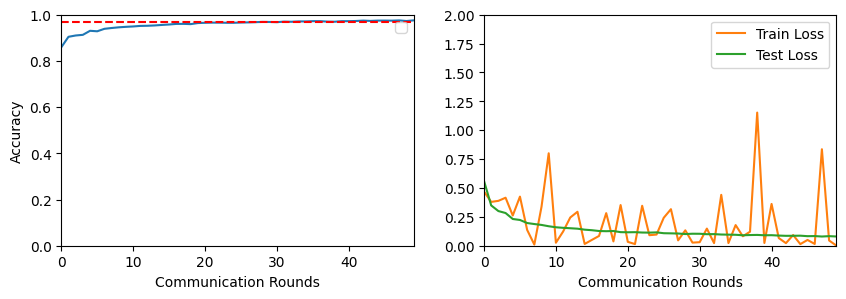

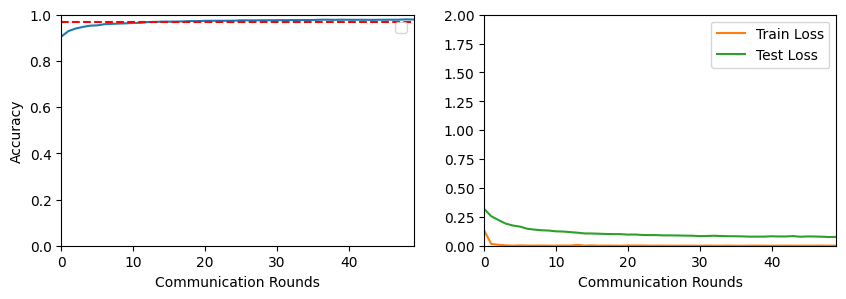

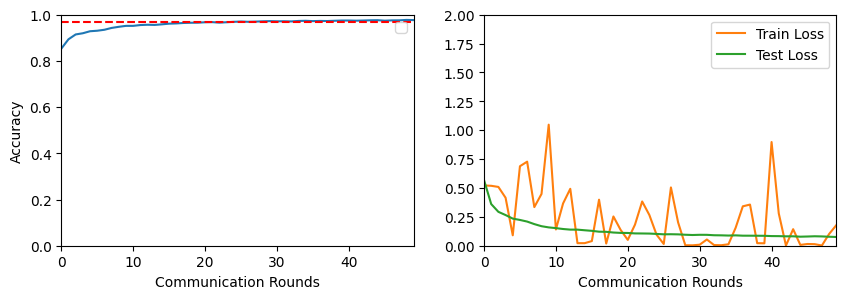

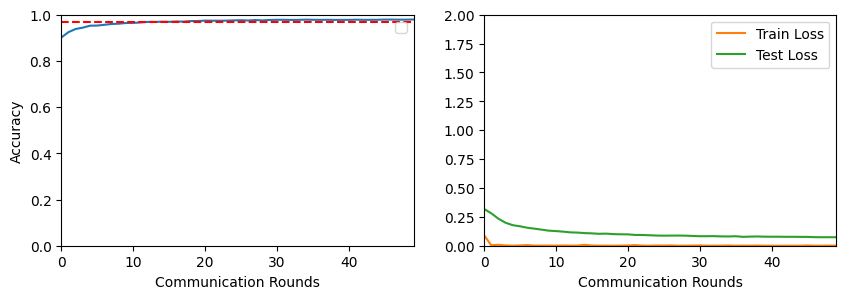

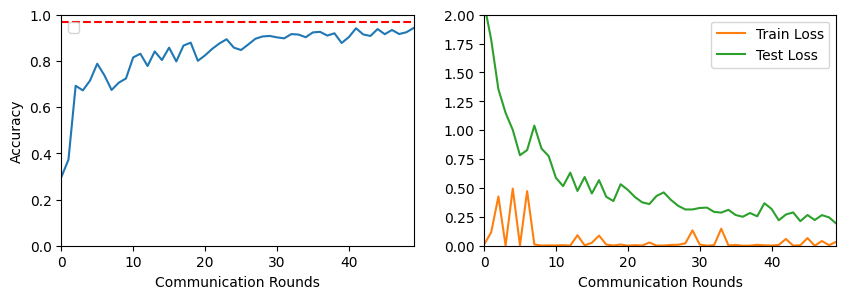

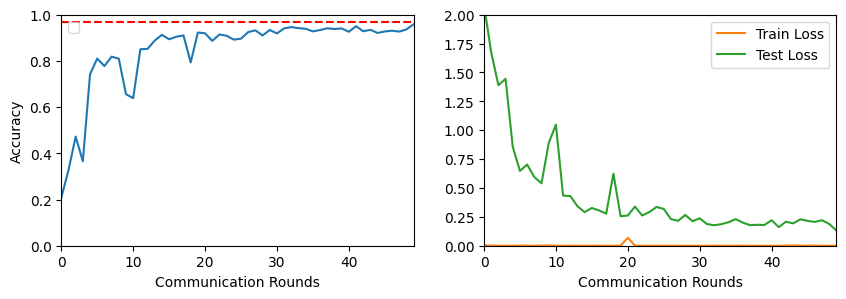

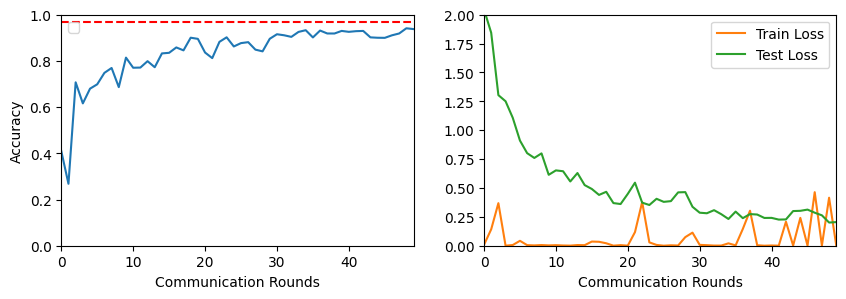

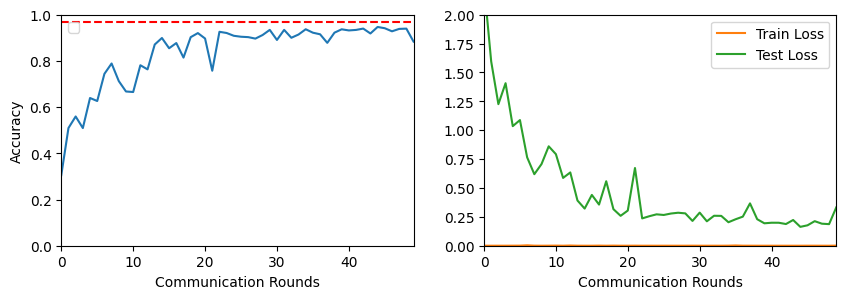

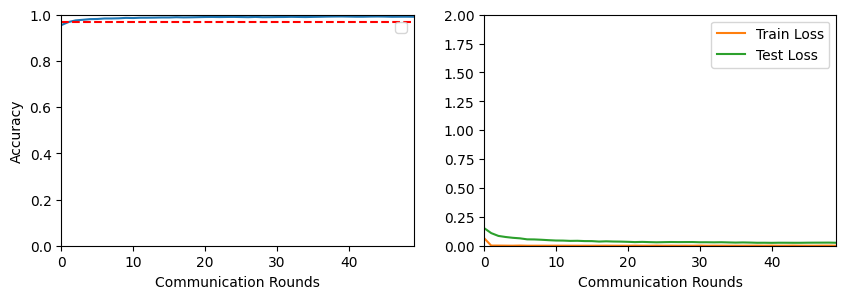

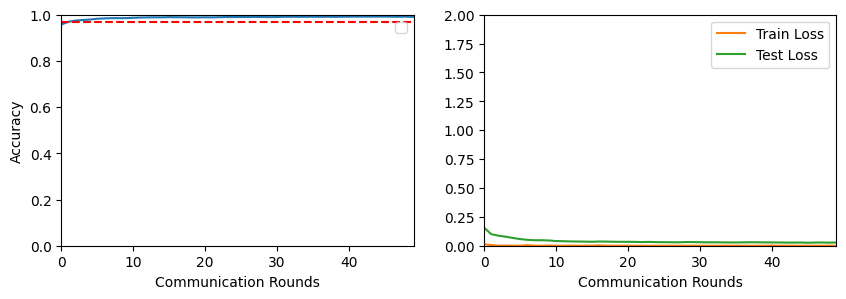

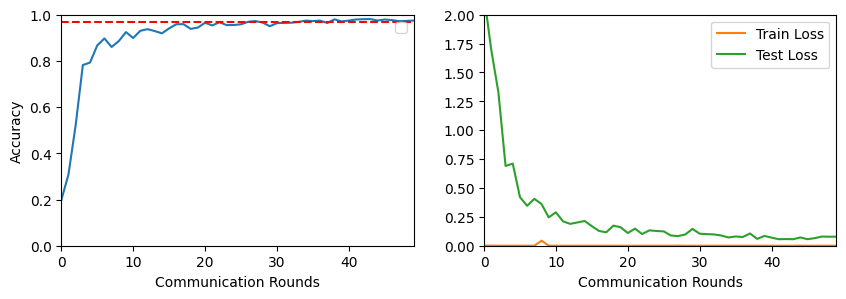

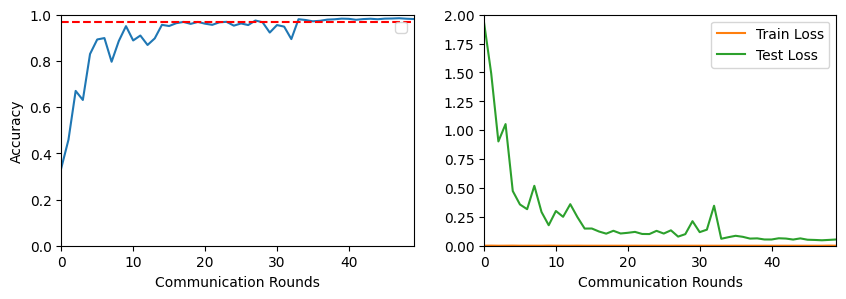

In [ ]:
# minist.ipynb
from itertools import product

from src.simulate import simulate
from src.helper import display_train_stats, ExperimentLogger, plot_accuracy
from src.config import *


c_lst = [10, ]
b_lst = [10, 50]
e_lst = [1, 5]

dataset = 'MNIST'
img_dir = f'{img_dir_root}/{dataset}'
stats_dir = f'{stats_dir_root}/{dataset}'

# mlp_iid
for c, b, e in list(product(c_lst, b_lst, e_lst)):
    label_parameters = f"C={c/100: .2f}, B={b},  E={e}"
    print(label_parameters)
    stats, kw = simulate(dataset, num_clients=100, num_participants=c, batch_size=b, num_local_epochs=e, num_rounds=50, learning_rate=0.01, target_accuracy=0.97, iid=True, mlp=True)
    name = f"{dataset}_{kw}_{c}_{b}_{e}"
    fig = display_train_stats(stats, title=name, label=label_parameters, target_accuracy=0.97)
    fig.savefig(f'{img_dir}/{kw}_{c}_{b}_{e}.png')

# mlp_noniid
for c, b, e in list(product(c_lst, b_lst, e_lst)):
    label_parameters = f"C={c/100: .2f}, B={b},  E={e}"
    print(label_parameters)
    stats, kw = simulate(dataset, num_clients=100, num_participants=c, batch_size=b, num_local_epochs=e, num_rounds=50, learning_rate=0.01, target_accuracy=0.97, iid=False, mlp=True)
    name = f"{dataset}_{kw}_{c}_{b}_{e}"
    fig = display_train_stats(stats, title=name, label=label_parameters, target_accuracy=0.97)
    fig.savefig(f'{img_dir}/{kw}_{c}_{b}_{e}.png')

# cnn_iid
for c, b, e in list(product(c_lst[:1], b_lst, e_lst[1:])):
    label_parameters = f"C={c/100: .2f}, B={b},  E={e}"
    print(label_parameters)
    stats, kw = simulate(dataset, num_clients=100, num_participants=c, batch_size=b, num_local_epochs=e, num_rounds=50, learning_rate=0.01, target_accuracy=0.99, iid=True, mlp=False)
    name = f"{dataset}_{kw}_{c}_{b}_{e}"
    fig = display_train_stats(stats, title=name, label=label_parameters, target_accuracy=0.97)
    fig.savefig(f'{img_dir}/{kw}_{c}_{b}_{e}.png')

# cnn_noniid
for c, b, e in list(product(c_lst[:1], b_lst, e_lst[1:])):
    label_parameters = f"C={c/100: .2f}, B={b},  E={e}"
    print(label_parameters)
    stats, kw = simulate(dataset, num_clients=100, num_participants=c, batch_size=b, num_local_epochs=e, num_rounds=50, learning_rate=0.01, target_accuracy=0.99, iid=False, mlp=False)
    name = f"{dataset}_{kw}_{c}_{b}_{e}"
    fig = display_train_stats(stats, title=name, label=label_parameters, target_accuracy=0.97)
    fig.savefig(f'{img_dir}/{kw}_{c}_{b}_{e}.png')


mlp_iid_10_10_5.npy
mlp_iid_10_50_5.npy
mlp_iid_10_50_1.npy
mlp_iid_10_10_1.npy


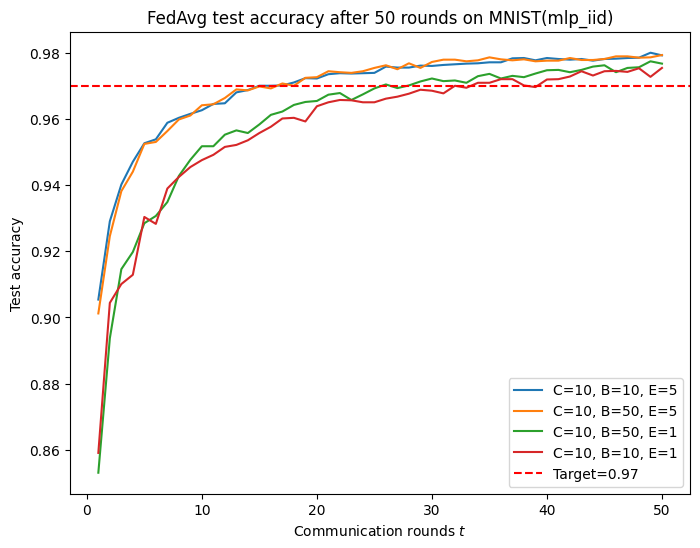

In [ ]:
plot_accuracy(dataset, 'mlp_iid', num_epoch=50)


mlp_noniid_10_10_1.npy
mlp_noniid_10_10_5.npy
mlp_noniid_10_50_5.npy
mlp_noniid_10_50_1.npy


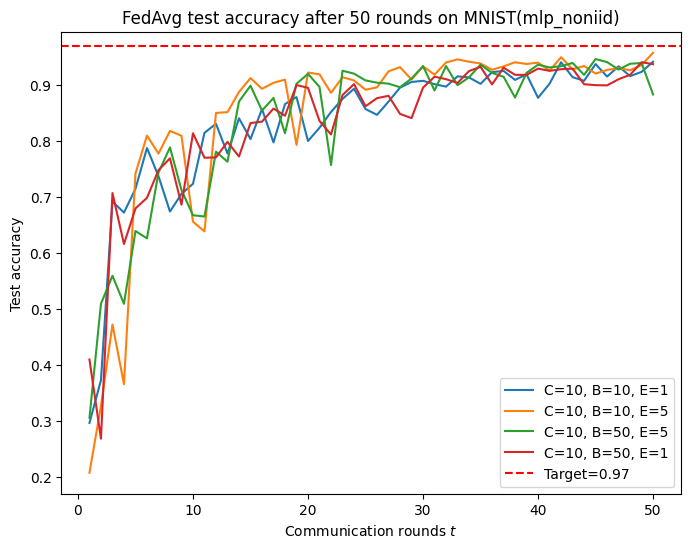

In [ ]:
plot_accuracy(dataset, 'mlp_noniid', num_epoch=50)

cnn_iid_10_10_5.npy
cnn_iid_10_50_5.npy


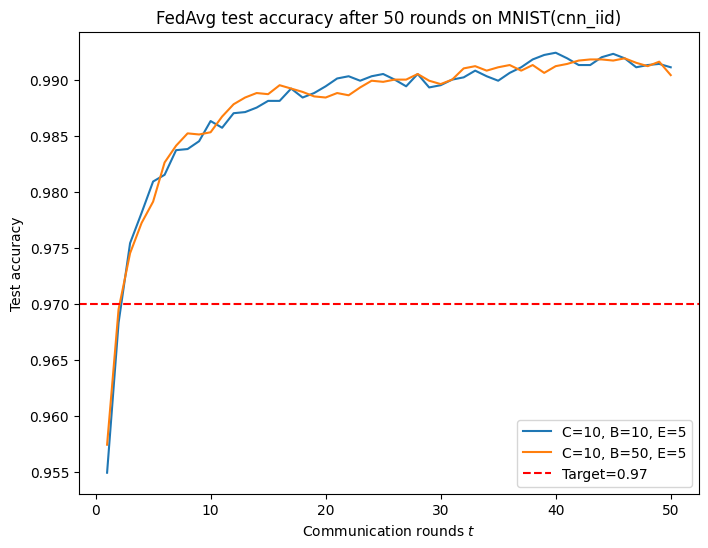

In [ ]:
plot_accuracy(dataset, 'cnn_iid', num_epoch=50)

cnn_noniid_10_10_5.npy
cnn_noniid_10_50_5.npy


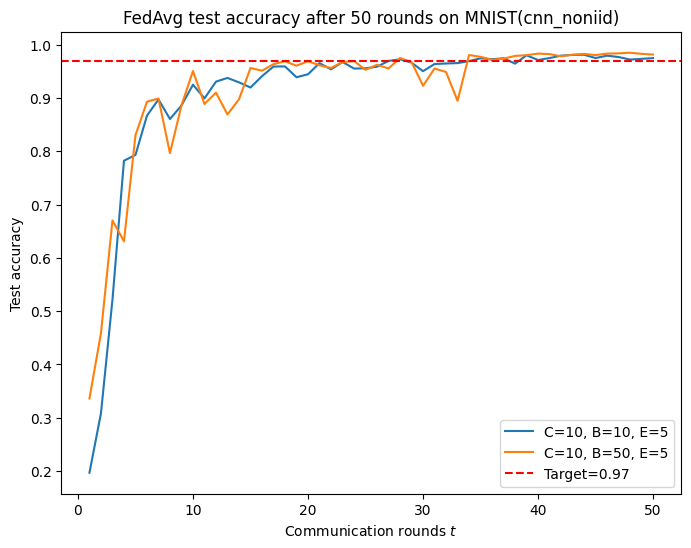

In [ ]:
plot_accuracy(dataset, 'cnn_noniid', num_epoch=50)